#### Imports 

In [1]:
import os
import cv2
import math
import pickle
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.optimizers import SGD
from keras.preprocessing import image
from keras.applications import ResNet50
from keras.models import Model, Sequential
from keras.layers.pooling import AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input


from utils import video_to_frame, create_row_pixels

%matplotlib inline

Using TensorFlow backend.


#### Preprocessing 

In [ ]:
# open the .txt file which have names of training videos
train = pd.read_csv(r"C:\Users\dbernsohn\Documents\projects\SVW\SVW.csv")

train = train[:-1]
train.head()

In [ ]:
try:
    frame_df = pd.read_csv('frame_df.csv')
except:
#     storing the frames from training videos
    frame_df = video_to_frame(train, path_to_videos = r"C:\Users\dbernsohn\Documents\projects\SVW\Videos", path_to_save = r"C:\Users\dbernsohn\Documents\Python Scripts\video_classification\train")
    frame_df.to_csv('frame_df.csv')

#### Build the labels 

In [ ]:
print("Train on classes: ", ', '.join(frame_df.Class.unique()[:5]))
data, labels = create_row_pixels(frame_df[frame_df.Class.isin(frame_df.Class.unique()[:5])], 'train')

In [2]:
save = False
if save:
    np.save('data.npy', data)

    with open('labels', 'wb') as fp:
        pickle.dump(labels, fp)

with open ('labels', 'rb') as fp:
    labels = pickle.load(fp)
    
data = np.load('data.npz')
data = data['a']

#### Split the data into train/test 

In [3]:
data = np.array(data)
labels = np.array(labels)
 
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
 
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.25, stratify=labels, random_state=42)

#### Create Generator 

In [4]:
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

valAug = ImageDataGenerator()

#### Create model 

In [5]:
baseModel = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


/home/rs/miniconda3/envs/nlp/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


#### Train the model from the last layer

In [6]:
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / 4)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

callbacks = [ModelCheckpoint('/mnt/tera/Audio/tmp/checkpoint/weights_improvement_{epoch:02d}.hdf5', save_best_only=True),
            EarlyStopping(monitor='val_acc', patience=2)]
    
print("[INFO] training head...")
batch_size = 32
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=batch_size),
    steps_per_epoch=len(trainX) // batch_size,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // batch_size,
    callbacks=callbacks,
    epochs=20, verbose = 1)

[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
197/197 [==============================] - 3517s 18s/step - loss: 1.5645 - accuracy: 0.3640 - val_loss: 1.0532 - val_accuracy: 0.5053


/home/rs/miniconda3/envs/nlp/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/20
197/197 [==============================] - 3535s 18s/step - loss: 1.0623 - accuracy: 0.5934 - val_loss: 0.9642 - val_accuracy: 0.5992
Epoch 3/20
197/197 [==============================] - 3515s 18s/step - loss: 0.8529 - accuracy: 0.6971 - val_loss: 0.9684 - val_accuracy: 0.6934
Epoch 4/20
197/197 [==============================] - 3524s 18s/step - loss: 0.7081 - accuracy: 0.7563 - val_loss: 0.8856 - val_accuracy: 0.7117
Epoch 5/20
197/197 [==============================] - 3457s 18s/step - loss: 0.6485 - accuracy: 0.7864 - val_loss: 0.5269 - val_accuracy: 0.7243
Epoch 6/20
197/197 [==============================] - 3438s 17s/step - loss: 0.5914 - accuracy: 0.8063 - val_loss: 0.5919 - val_accuracy: 0.7629
Epoch 7/20
197/197 [==============================] - 3522s 18s/step - loss: 0.5324 - accuracy: 0.8284 - val_loss: 0.4631 - val_accuracy: 0.7721
Epoch 8/20
197/197 [==============================] - 3461s 18s/step - loss: 0.5097 - accuracy: 0.8281 - val_loss: 0.4712 - val_ac

In [7]:
df = pd.DataFrame(H.history)
df.head()

,val_loss,val_accuracy,loss,accuracy
0,1.053249,0.505288,1.561575,0.364027
1,0.964242,0.599227,1.061728,0.593436
2,0.968367,0.693385,0.853156,0.697148
3,0.885649,0.711733,0.709477,0.756253
4,0.526938,0.724288,0.646240,0.786363


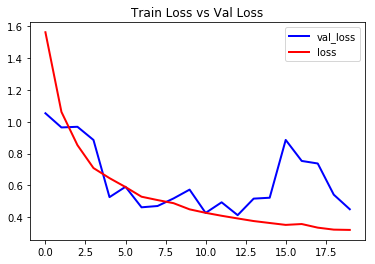

In [8]:
plt.plot('val_loss', data=df, marker='', color='blue', linewidth=2)
plt.plot('loss', data=df, marker='', color='red', linewidth=2)
plt.title('Train Loss vs Val Loss')
plt.legend()

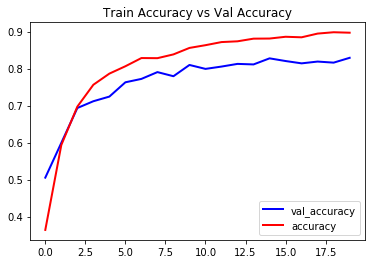

In [9]:
plt.plot('val_accuracy', data=df, marker='', color='blue', linewidth=2)
plt.plot('accuracy', data=df, marker='', color='red', linewidth=2)
plt.title('Train Accuracy vs Val Accuracy')
plt.legend()